In [23]:
from ase.io import read, write
from ase import atoms
from ase.calculators import cp2k
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
NaCl_crystal = read('NaCl.pdb')

In [3]:
cp2k_input = """
&FORCE_EVAL
  METHOD Fist
  &MM
    &FORCEFIELD
      &CHARGE
        ATOM Na
        CHARGE +1.000
      &END CHARGE
      &CHARGE
        ATOM Cl
        CHARGE -1.000
      &END CHARGE
      &NONBONDED
        &BMHFT
          map_atoms NA NA
          atoms NA NA
          RCUT 10.0
        &END BMHFT
        &BMHFT
          map_atoms NA CL
          atoms NA CL
          RCUT 10.0
        &END BMHFT
        &BMHFT
          map_atoms CL CL
          atoms CL CL
          RCUT 10.0
        &END BMHFT
      &END NONBONDED
    &END FORCEFIELD
    &POISSON
      &EWALD
        EWALD_TYPE spme
        ALPHA .5
        GMAX 40
        O_SPLINE 6
      &END EWALD
    &END POISSON
  &END MM
  &SUBSYS
    &CELL
      ABC 22.480 22.480 22.480
    &END CELL
    &TOPOLOGY
      &GENERATE
         BONDLENGTH_MAX [bohr] 6.5
      &END
    &END TOPOLOGY
  &END SUBSYS
&END FORCE_EVAL
&MOTION
  &MD
    ENSEMBLE NVT
    STEPS 10
    TIMESTEP 2.5
    TEMPERATURE 300.0
    &THERMOSTAT
      &NOSE
        LENGTH 3
        YOSHIDA 3
        TIMECON 1000
        MTS 2
      &END NOSE
      &PRINT
        &ENERGY
        &END
      &END
    &END
  &END MD
&END MOTION
"""

In [4]:
with cp2k.CP2K(
    inp=cp2k_input,
    basis_set=None,
    basis_set_file=None,
    max_scf=None,
    cutoff=None,
    force_eval_method=None,
    potential_file=None,
    poisson_solver=None,
    pseudo_potential=None,
    stress_tensor=False,
    xc=None,
    label='NaCl') as calc:
        calc.command="cp2k_shell.psmp"
        energy = calc.get_potential_energy(atoms=NaCl_crystal)
        print(NaCl_crystal, energy)
        
        vac1 = NaCl_crystal[[atom.index for atom in NaCl_crystal if atom.index != 1]]
        energy = calc.get_potential_energy(atoms=vac1)
        print(vac1, energy)
                
        NaCl_crystal.positions[[1, 3]] = NaCl_crystal.positions[[3, 1]]
        vac2 = NaCl_crystal[[atom.index for atom in NaCl_crystal if atom.index != 1]]
        energy = calc.get_potential_energy(atoms=vac2)
        print(vac2, energy)


/home/mattw/miniconda3/envs/pymatgen/lib/python3.13/site-packages/ase/calculators/cp2k.py:319: UserWarning: ASE may stall when passing large structures to MPI versions of CP2K. Consider using `set_pos_file=True`.
  warn('ASE may stall when passing large structures'


Atoms(symbols='Cl256Na256', pbc=True, cell=[22.48, 22.48, 22.48], atomtypes=..., bfactor=..., occupancy=..., residuenames=..., residuenumbers=...) -2061.3166833721
Atoms(symbols='Cl255Na256', pbc=True, cell=[22.48, 22.48, 22.48], atomtypes=..., bfactor=..., occupancy=..., residuenames=..., residuenumbers=...) -2054.1004703156
Atoms(symbols='Cl255Na256', pbc=True, cell=[22.48, 22.48, 22.48], atomtypes=..., bfactor=..., occupancy=..., residuenames=..., residuenumbers=...) -2054.1004703156


In [ ]:
import numpy as np

from ase.calculators.emt import EMT
from ase.constraints import FixAtoms
from ase.io import read
from ase.mep import NEB
from ase.optimize.fire import FIRE as QuasiNewton

# Read the previous configurations
initial = vac1
final = vac2

for ends in initial, final:
    ends.calc =cp2k.CP2K(
    inp=cp2k_input,
    basis_set=None,
    basis_set_file=None,
    max_scf=None,
    cutoff=None,
    force_eval_method=None,
    potential_file=None,
    poisson_solver=None,
    pseudo_potential=None,
    stress_tensor=False,
    xc=None,
    label='NaCl_vac')
    ends.calc.command="cp2k_shell.psmp"
    #config.set_constraint(constraint)



In [26]:
relax = QuasiNewton(initial)
relax.run(fmax=0.05)
print('initial state:', initial.calc.get_potential_energy())
write('initial.traj', initial)

relax = QuasiNewton(final)
relax.run(fmax=0.05)
print('final state:', final.calc.get_potential_energy())
write('final.traj', final)

      Step     Time          Energy          fmax
FIRE:    0 10:13:11    -2056.154212        0.038825
initial state: -2056.1542115166
      Step     Time          Energy          fmax
FIRE:    0 10:13:11    -2056.154212        0.038825
final state: -2056.1542115166


In [53]:
#  Make 9 images (note the use of copy)
configs = [initial.copy() for i in range(8)] + [final]

# As before, fix the Cu atoms
#constraint = FixAtoms(mask=[atom.symbol != 'N' for atom in initial])

for config in configs:
    config.calc =cp2k.CP2K(
    inp=cp2k_input,
    #basis_set=None,
    #basis_set_file=None,
    #max_scf=None,
    #cutoff=None,
    force_eval_method=None,
    #potential_file=None,
    #poisson_solver=None,
    #pseudo_potential=None,
    #stress_tensor=False,
    #xc=None,
    label='NaCl_vac')
    config.calc.command="cp2k_shell.psmp"
    #config.set_constraint(constraint)

# Make the NEB object, interpolate to guess the intermediate steps
band = NEB(configs, )
band.interpolate()

relax = QuasiNewton(band, trajectory='A2B.traj')

# Do the calculation
relax.run()

# Compare intermediate steps to initial energy
e0 = configs[0].get_potential_energy()
for config in configs:
    d = config[-2].position - config[-1].position
    print(np.linalg.norm(d), config.get_potential_energy() - e0)

/home/mattw/miniconda3/envs/pymatgen/lib/python3.13/site-packages/ase/calculators/cp2k.py:319: UserWarning: ASE may stall when passing large structures to MPI versions of CP2K. Consider using `set_pos_file=True`.
  warn('ASE may stall when passing large structures'


      Step     Time          Energy          fmax
FIRE:    0 14:55:22    -2054.567413        1.932585
FIRE:    1 14:55:23    -2054.664400        1.704682
FIRE:    2 14:55:23    -2054.823627        1.309114
FIRE:    3 14:55:24    -2054.995794        0.836647
FIRE:    4 14:55:24    -2055.141061        0.460924
FIRE:    5 14:55:25    -2055.237662        0.377540
FIRE:    6 14:55:25    -2055.295964        0.283328
FIRE:    7 14:55:26    -2055.332475        0.395456
FIRE:    8 14:55:27    -2055.357734        0.444961
FIRE:    9 14:55:27    -2055.375955        0.412474
FIRE:   10 14:55:28    -2055.387637        0.317941
FIRE:   11 14:55:28    -2055.392977        0.227943
FIRE:   12 14:55:29    -2055.396320        0.222259
FIRE:   13 14:55:29    -2055.402680        0.211096
FIRE:   14 14:55:30    -2055.411442        0.194819
FIRE:   15 14:55:30    -2055.421776        0.174010
FIRE:   16 14:55:31    -2055.432732        0.149410
FIRE:   17 14:55:31    -2055.443358        0.127728
FIRE:   18 14:

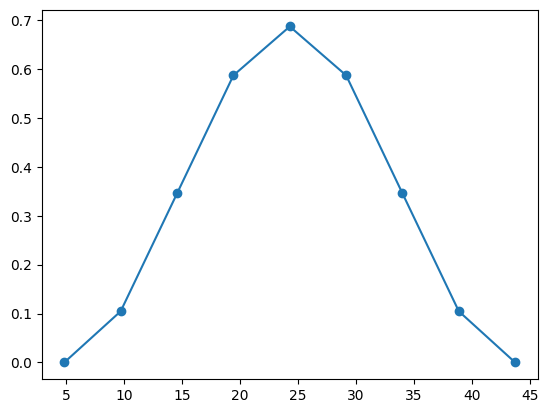

In [60]:
e0 = configs[0].get_potential_energy()
distance, energy = [], []
tot_distance = 0
for config in configs:
    d = config[-2].position - config[-1].position
    tot_distance += np.linalg.norm(d)
    distance.append(tot_distance)
    energy.append(config.get_potential_energy() - e0)
plt.plot(distance, energy)
plt.scatter(distance, energy)

In [52]:
import ase
for i in range(1, 9):
    write("image_{}.xyz".format(i), configs[i])